## Implementing a multi-level perceptron to make a character level name generator

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Building the vocabulary of characters and the mappings to and from char to int

In [46]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Building the Dataset

In [47]:
block_size = 3 # Context length, how many characters are considered to predict the next one.
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [48]:
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64


## Making the simple model

In [50]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [51]:
n_embd = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # For reproducability
C = torch.randn((vocab_size, n_embd), generator=g) # Table Lookup

# Fixes tanh layer too saturated
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
# torch.nn.init.kaiming_normal_(W1, nonlinearity='tanh') # Kaiming Initialization in stead of multiplication above
# Not necessary if we do batch normalization
#b1 = torch.randn(n_hidden, generator=g) * 0.01 

# Fixes the softmax being confidentely wrong initially making the logits close to 0
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Want to make close to 0 but not 0 for better init
b2 = torch.randn(vocab_size, generator=g) * 0.0 # Initializing to 0 for a better initialization

# Batch Normalization Parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Number of parameters
for p in parameters:
    p.requires_grad = True

12297


In [52]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X and Y

    # Forward pass
    emb = C[Xb] # Embedding based on C (encoding each character)
    embcat = emb.view(emb.shape[0], -1)
    # Linear Layer
    hpreact = embcat @ W1 # Hidden layer without activation
    # Batch Normalization Layer
    # ----------------------------------------
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_running
    # --------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Output Layer
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: Batch Loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: Batch Loss = 3.3147
  10000/ 200000: Batch Loss = 2.1984
  20000/ 200000: Batch Loss = 2.3375
  30000/ 200000: Batch Loss = 2.4359
  40000/ 200000: Batch Loss = 2.0119
  50000/ 200000: Batch Loss = 2.2595
  60000/ 200000: Batch Loss = 2.4775
  70000/ 200000: Batch Loss = 2.1020
  80000/ 200000: Batch Loss = 2.2788
  90000/ 200000: Batch Loss = 2.1862
 100000/ 200000: Batch Loss = 1.9474
 110000/ 200000: Batch Loss = 2.3010
 120000/ 200000: Batch Loss = 1.9837
 130000/ 200000: Batch Loss = 2.4523
 140000/ 200000: Batch Loss = 2.3839
 150000/ 200000: Batch Loss = 2.1987
 160000/ 200000: Batch Loss = 1.9733
 170000/ 200000: Batch Loss = 1.8668
 180000/ 200000: Batch Loss = 1.9973
 190000/ 200000: Batch Loss = 1.8347


Plotting some stats.

When dealing with the tanh activation, tanh is a squashing function, squashing values to a range of 1 and -1 smoothly. If the distribution of the values in h centers around 1 and -1, we will deal with vanishing gradients since the derivative is $1-t^2 * ...$

In the neuron activation, if we have a whole column in yellow, we have a dead neuron, the neuron will never learn. We shouldn't have as many yellow neurons either.

To solve this vanishing gradients issue, we can change the initialization of W1 and b1 to make them smaller. As a consequence, the preactivation will be distributed ranging between smaller values and the activated layer will be more evenly spread in the middle (not the tails, which was previously the case)

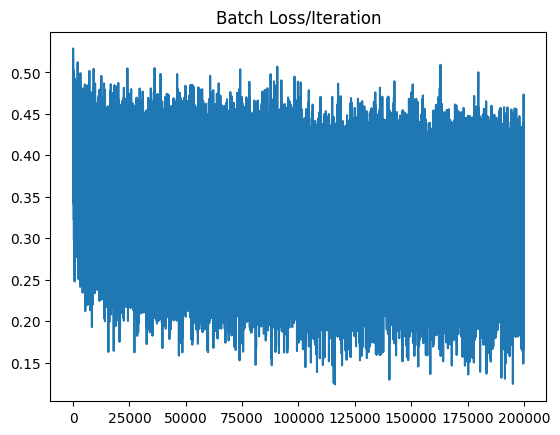

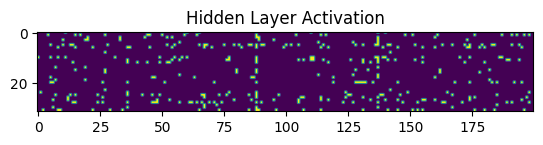

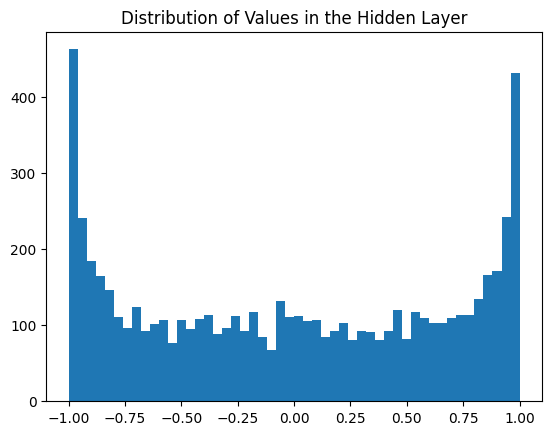

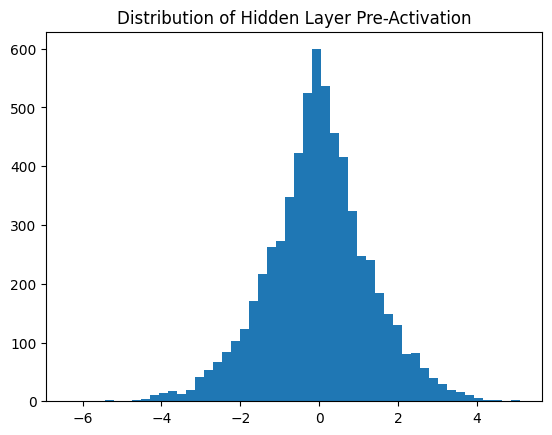

In [53]:
plt.plot(lossi)
plt.title("Batch Loss/Iteration")

plt.figure()
plt.imshow(h.abs() > .99)
plt.title("Hidden Layer Activation")

plt.figure()
plt.hist(h.view(-1).tolist(), 50)
plt.title("Distribution of Values in the Hidden Layer")

plt.figure()
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title("Distribution of Hidden Layer Pre-Activation");


Calibrate the batch norm at the end of training

Simple Model's Performance

In [43]:
@torch.no_grad() # Decorator disables gradient tracking
def split_loss(split):
    x, y = { 
        'train': (Xtr, Ytr),
        'validation': (Xval, Yval),
        'test': (Xte, Yte)
        }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer without activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('validation')


train 2.0668270587921143
validation 2.104844808578491


Sampling from the simple model

In [315]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1 # Hidden layer without activation
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

abebaylan.
kossin.
badrianna.
lyananton.
kastiann.
emamiyah.
essla.
lecpa.
veanna.
hura.
ester.
saena.
sorie.
yonna.
keakailyn.
leya.
sanfai.
johnn.
senzley.
yesten.


Visualizing the Embeddings Before we Scale them

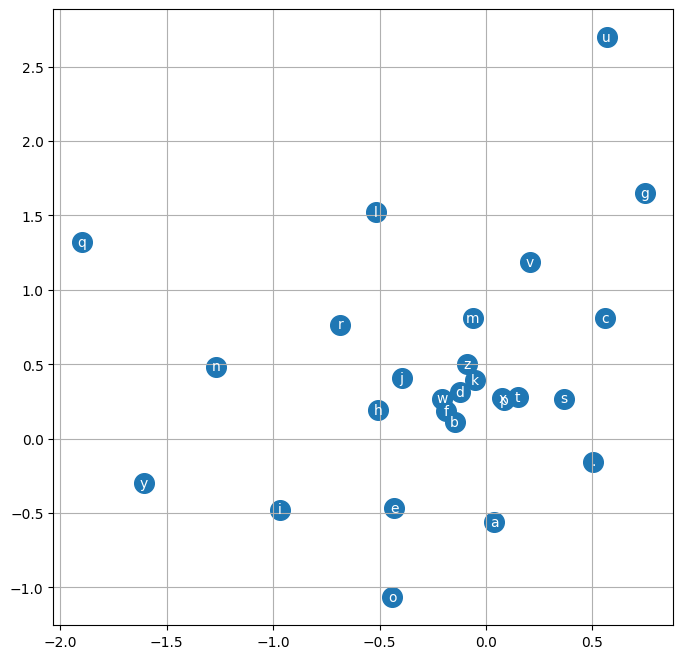

In [237]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

## Training a deeper network (torchifying)

In [88]:
# Similar to the torch.nn.Linear class
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# Similar to the torch.nn.BatchNorm1d
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running "Momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True) # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to standard normal
        self.out = self.gamma * xhat + self.beta
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_mean = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# Just calculates tanh
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # Dimensionality of the characters embedding vectors
n_hidden = 100 # Num of neurons in a hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # Embeddings

# Creating the layers
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# Changing the initialization
with torch.no_grad():
    # Avoiding making it confident for wrong choices with more uniform probabilities 
    # layers[-1].weight *= 0.1 This is one approach, but if we use a bn layer in the end we need to do the following
    layers[-1].gamma *= 0.1
    # All other layers: Apply gain from Kaiming Initialization
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # Number of total parameters
for p in parameters:
    p.requires_grad = True


47551


In [96]:
max_steps = 200000
batch_size = 32
lossi = [] # Losses
ud = [] # Update to data ratios

for i in range(max_steps):
    # Minibatch Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X and Y

    # Forward pass
    emb = C[Xb] # Embedding based on C (encoding each character)
    x = emb.view(emb.shape[0], -1) # Concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # Loss Function
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: Batch Loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # if i > 1000:
    #     break # AFTER_DEBUG: Would take out to run a full optimization

      0/ 200000: Batch Loss = 2.9130
  10000/ 200000: Batch Loss = 2.1731
  20000/ 200000: Batch Loss = 2.2163
  30000/ 200000: Batch Loss = 2.4038
  40000/ 200000: Batch Loss = 2.1651
  50000/ 200000: Batch Loss = 2.2042
  60000/ 200000: Batch Loss = 2.4721
  70000/ 200000: Batch Loss = 2.1767
  80000/ 200000: Batch Loss = 2.2315
  90000/ 200000: Batch Loss = 2.1104
 100000/ 200000: Batch Loss = 1.8311
 110000/ 200000: Batch Loss = 2.3730
 120000/ 200000: Batch Loss = 2.0779
 130000/ 200000: Batch Loss = 1.9560
 140000/ 200000: Batch Loss = 1.6884
 150000/ 200000: Batch Loss = 1.9698
 160000/ 200000: Batch Loss = 1.5629
 170000/ 200000: Batch Loss = 2.0064
 180000/ 200000: Batch Loss = 1.6357
 190000/ 200000: Batch Loss = 2.0132


layer 2 (      Tanh): mean -0.29, std 0.83, saturated: 53.53%
layer 5 (      Tanh): mean -0.22, std 0.87, saturated: 57.78%
layer 8 (      Tanh): mean -0.20, std 0.88, saturated: 57.09%
layer 11 (      Tanh): mean -0.34, std 0.85, saturated: 59.31%
layer 14 (      Tanh): mean -0.24, std 0.90, saturated: 66.97%


Text(0.5, 1.0, 'activation distribution')

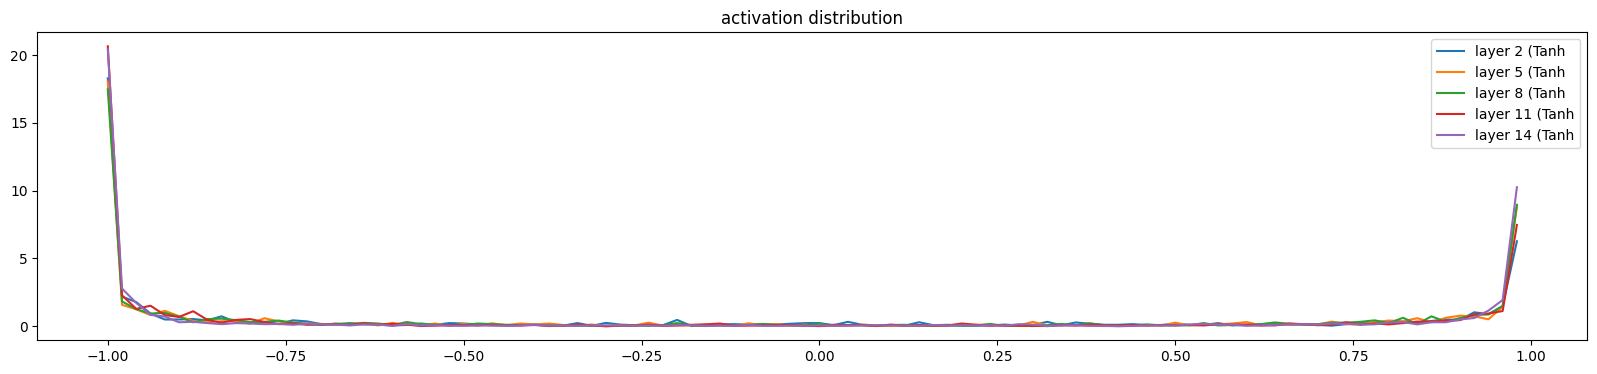

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000156, std 3.737198e-03
layer 5 (      Tanh): mean -0.000082, std 3.617696e-03
layer 8 (      Tanh): mean -0.000103, std 3.680448e-03
layer 11 (      Tanh): mean -0.000059, std 3.476228e-03
layer 14 (      Tanh): mean -0.000082, std 5.051486e-03


Text(0.5, 1.0, 'gradient distribution')

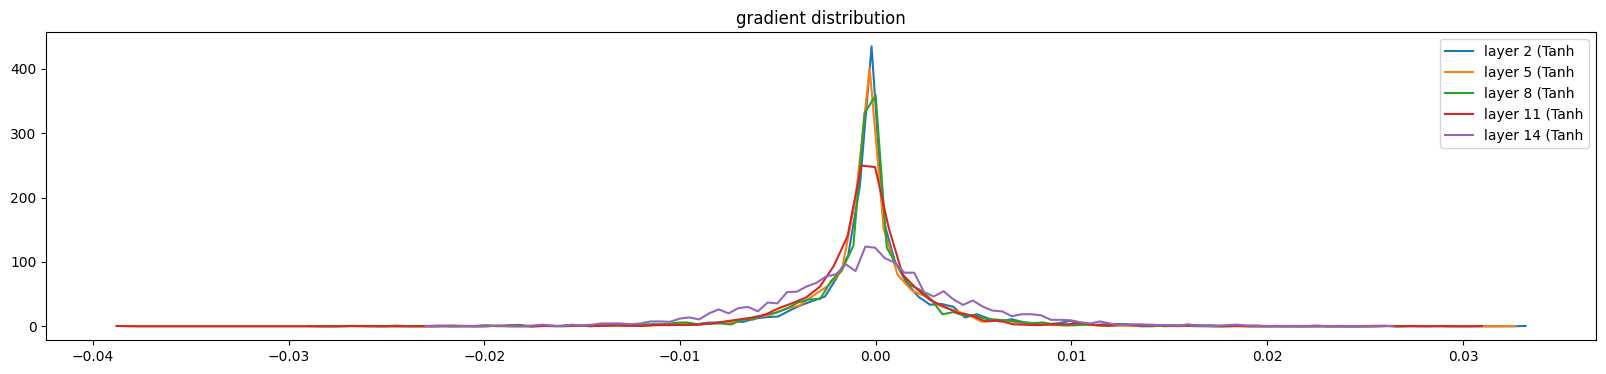

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.001593 | std 1.428409e-02 | grad:data ratio 1.244086e-02
weight  (30, 100) | mean -0.000222 | std 9.012609e-03 | grad:data ratio 1.968409e-02
weight (100, 100) | mean +0.000496 | std 6.624429e-03 | grad:data ratio 2.381748e-02
weight (100, 100) | mean +0.000221 | std 6.844370e-03 | grad:data ratio 2.602904e-02
weight (100, 100) | mean +0.000025 | std 6.954495e-03 | grad:data ratio 2.721016e-02
weight (100, 100) | mean +0.000372 | std 6.205444e-03 | grad:data ratio 2.457493e-02
weight  (100, 27) | mean +0.000142 | std 1.483181e-02 | grad:data ratio 4.394718e-02


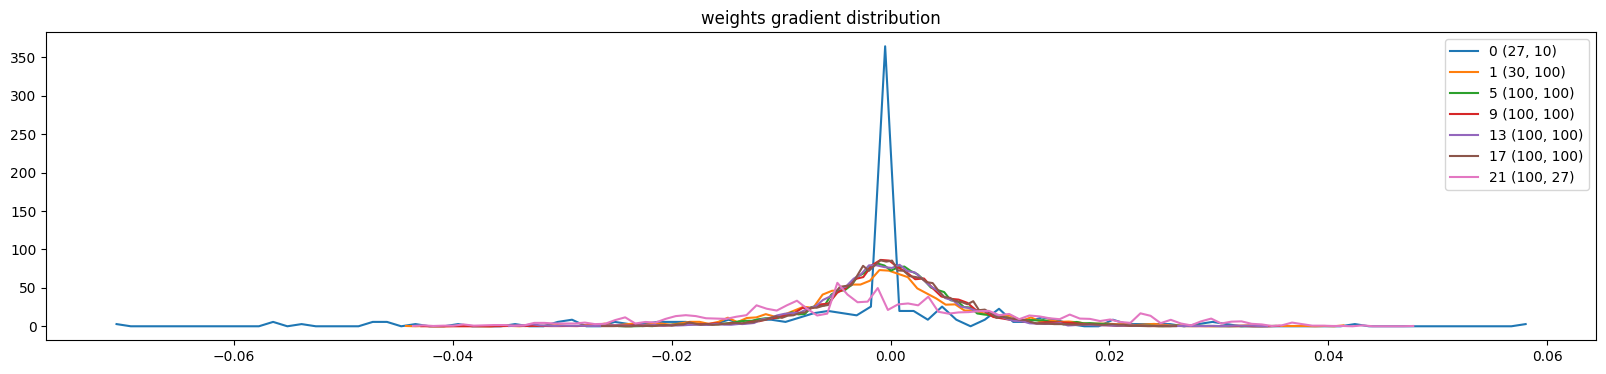

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

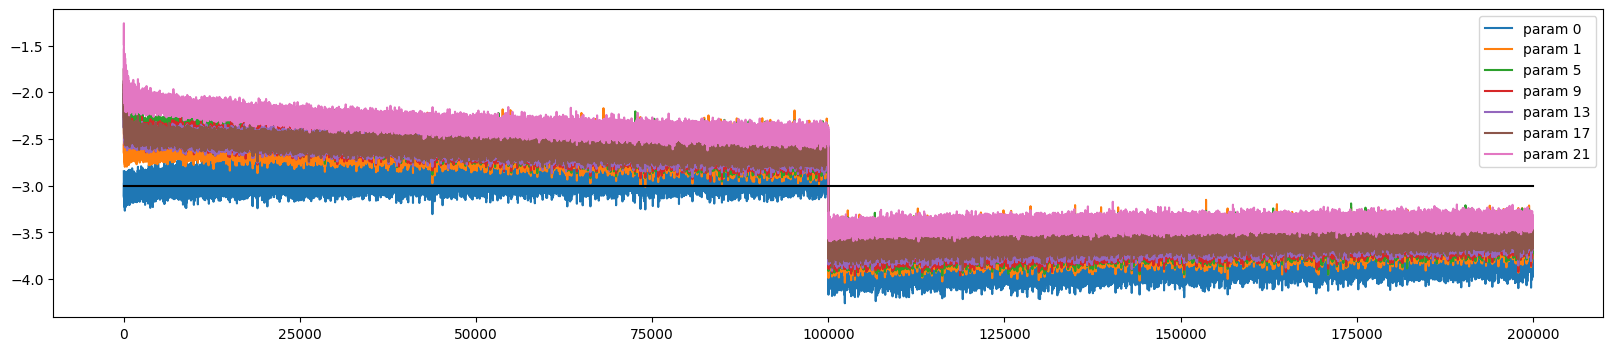

In [100]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [101]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9659168720245361
val 2.0827386379241943


In [102]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahxand.
hari.
kimilia.
atlannah.
sky.
mahni.
faperric.
kaeli.
nellara.
chaily.
kaleigh.
ham.
port.
quintis.
lilah.
jadique.
jero.
dearistin.
jenni.
sabee.
